In [19]:
# Main goals of this excercise are to explore the dataset and find
# 1) occurences of bikes being moved by a maintenance crew
# 2) bikes that were stolen or taken for way longer than necessary given the traveled distance
# 3) timeseries view of the number of bikes in each station

import pandas as pd
import numpy as np
import tqdm
from google.cloud import bigquery
import pandas as pd
import pandas_gbq as gpd
import matplotlib.pyplot as plt
import queries as q

project_id = 'cab-law'
client = bigquery.Client(project=project_id)

In [3]:
# Let's take a look at the data model
query = """
    SELECT * FROM `bigquery-public-data.new_york.citibike_trips`
    limit 10;
"""
sample = gpd.read_gbq(query, project_id=project_id)
sample.head()


Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,1257,2015-11-08 12:47:18+00:00,2015-11-08 13:08:16+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,3102,Driggs Ave & Lorimer St,40.721791,-73.950415,14622,Subscriber,1983,male
1,1819,2016-03-12 15:07:43+00:00,2016-03-12 15:38:03+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,305,E 58 St & 3 Ave,40.760958,-73.967245,20955,Subscriber,1991,male
2,1024,2016-05-16 07:22:51+00:00,2016-05-16 07:39:55+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,282,Kent Ave & S 11 St,40.707645,-73.968415,22800,Subscriber,1970,male
3,2352,2016-06-06 17:58:29+00:00,2016-06-06 18:37:41+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,79,Franklin St & W Broadway,40.719116,-74.006667,25198,Subscriber,1964,male
4,1576,2015-10-18 16:12:03+00:00,2015-10-18 16:38:19+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,15006,Subscriber,1984,female


In [4]:
# Lets get some info about this dataset.
info_query = """
    SELECT count(distinct(bikeid)) as num_bikes, count(*) as num_trips, 
    count(distinct(start_station_id)) as num_stations FROM `bigquery-public-data.new_york.citibike_trips`
"""
info = gpd.read_gbq(info_query, project_id=project_id)
print(info)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
   num_bikes  num_trips  num_stations
0      11852   33319019           655


In [5]:
%%capture
# use magic %%capture because i can't figure out how to disable the progress bar in pandas_gbq.
# Let's use use_bqstorage_api=True to speed things up

# Let's answer question #1 by finding all bikes that started at a station different than the one it last stopped at
# after grouping by bikeid and sorting by starttime
results = gpd.read_gbq(q.moved_bikes_by_station_id, project_id=project_id, use_bqstorage_api=True).dropna()


In [6]:
# group by bikeid, order by starttime. Find all rows where 
print(results[['bikeid','start_station_id', 'end_station_id', 'prev_end_station_id']].head())
print("number of rows is {}".format(len(results)))
print("number of bikes moved is {}".format(len(results.groupby(['bikeid']))))
print("number of stations moved is {}".format(len(results.groupby(['start_station_id']))))

   bikeid  start_station_id  end_station_id  prev_end_station_id
1   14529               147             505                  306
2   14529               521             229                  347
3   14529               271             217                  353
4   14529               253             463                  144
5   14529               383             293                  368
number of rows is 2582817
number of bikes moved is 11784
number of stations moved is 649


In [7]:
%%capture
# ~33M rows and ~2.5M rows where start_station_id != prev_stop_station_id.
# that means ~7% of trips started at a station where it wasn't stopped at. That's higher than expected.
# lets verify these numbers by checking against lat/long rather than station_id
import queries as q
lat_long_results = gpd.read_gbq(q.moved_bikes_lat_long, project_id=project_id, use_bqstorage_api=True).dropna()


In [8]:
# group by bikeid, order by starttime. Find all rows where 
print(lat_long_results[['start_station_latitude', 'start_station_longitude','prev_end_station_latitude', 'prev_end_station_longitude']].head())
print("number of rows is {}".format(len(lat_long_results)))
print("number of bikes moved is {}".format(len(lat_long_results.groupby(['bikeid']))))
print("number of stations moved is {}".format(len(lat_long_results.groupby(['start_station_id']))))

   start_station_latitude  start_station_longitude  prev_end_station_latitude  \
2               40.685282               -73.978058                  40.685396   
3               40.735439               -73.994539                  40.698399   
4               40.735238               -74.000271                  40.730386   
5               40.769155               -73.981918                  40.762288   
6               40.756458               -73.993722                  40.718939   

   prev_end_station_longitude  
2                  -73.974315  
3                  -73.980689  
4                  -74.002150  
5                  -73.983362  
6                  -73.992663  
number of rows is 2295018
number of bikes moved is 11775
number of stations moved is 649


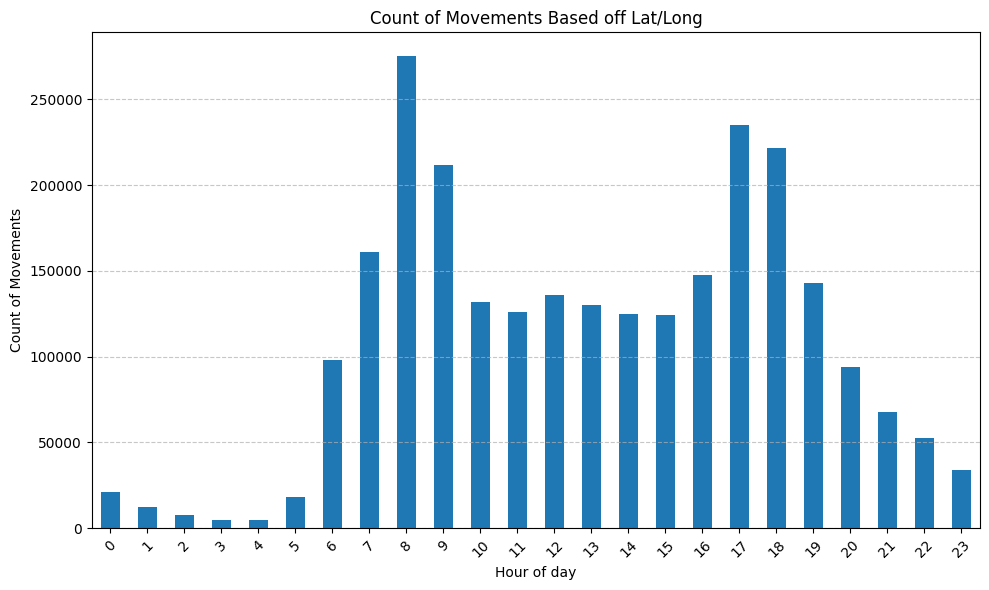

In [12]:
# numbers don't match up exactly when comparing with stationID but we're still at the ~7% number.
# lets go back to using stationID
# We also know that bikes most often get moved in the mornings and evenings. Do we see that in our data?

results['time_of_day'] = results['starttime'].dt.hour

# Count occurrences of each time of day
time_of_day_counts = results['time_of_day'].value_counts().sort_index()

# Plot the count of occurrences against the time of day
plt.figure(figsize=(10, 6))
time_of_day_counts.plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Count of Movements')
plt.title('Count of Movements Based off Lat/Long')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

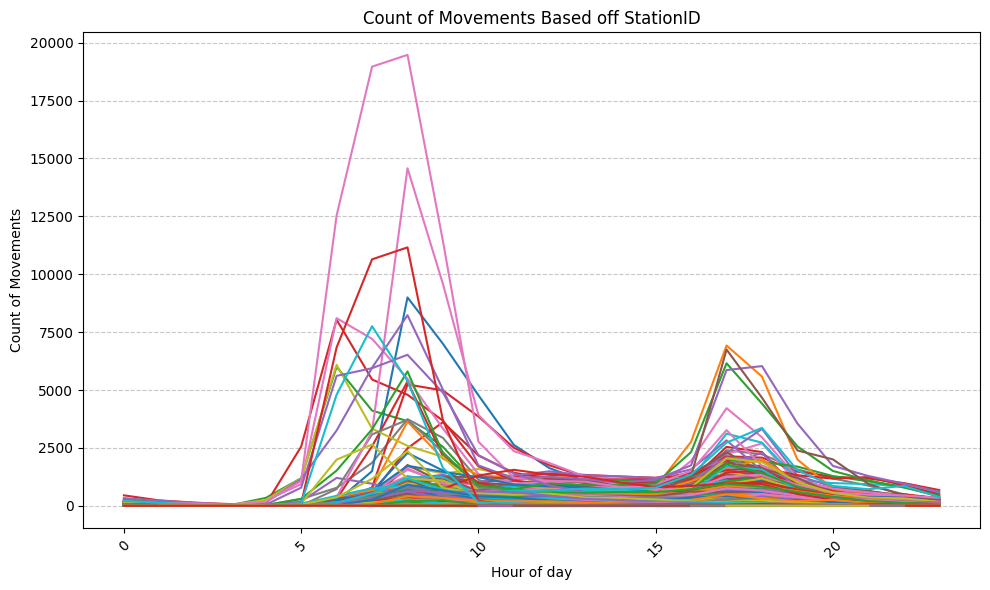

In [16]:
# This mostly confirms our suspicion that most technicians are moving bikes before and after people commute
# Still we would like to see more similar behavior at certain hours in the day. 
# Maybe if we group by station_id? Since some stations need bikes moved in the morning and others at night.

results['time_of_day'] = results['starttime'].dt.hour

# Group results by stationID and time_of_day, and count occurrences
grouped_counts = results.groupby(['start_station_id', 'time_of_day']).size().reset_index(name='count')

# Plot line graphs for each stationID
plt.figure(figsize=(10, 6))
for stationID, group in grouped_counts.groupby('start_station_id'):
    plt.plot(group['time_of_day'], group['count'], label=f'Station {stationID}')

# Add labels and title to the plot
plt.xlabel('Hour of day')
plt.ylabel('Count of Movements')
plt.title('Count of Movements Based off StationID')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
# This looks a lot better. The highs are much higher and the lows much lower.
# We can now be fairly confident in our analysis